# <img src="./assets/course-icon.png" style="height:50px;display:inline"> ECE 046211 - Technion - Deep Learning
---

#### <a href="https://taldatech.github.io">Tal Daniel</a>

## Tutorial 07 - Sequential Tasks - Recurrent Neural Networks and Transformers
---
<center><img src="./assets/rnn_1.jpg" style="height:200px"></center>

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* [Natural Language Processing and Sequences](#-Natural-Language-Processing-and-Sequences)
* [Text Preprocessing](#-Text-Preprocessing)
* [Evaluation in NLP - Perplexity and BLEU](#-Evaluation-in-NLP---Perplexity-and-BLEU)
* [Recurrent Neural Networks (RNNs)](#-Recurrent-Neural-Networks-(RNNs))
* [Backpropagation Through Time (BPTT)](#-Backpropagation-Through-Time-(BPTT))
* [Long Term Short Memory (LSTM)](#-Long-Term-Short-Memory-(LSTM))
* [Gated Recurrent Unit (GRU)](#-Gated-Recurrent-Unit-(GRU))
* [ Receptence, Weight, Key and Value (RWKV) - New Frontiers in RNNs](#-Receptence,-Weight,-Key-and-Value-(RWKV)---New-Frontiers-in-RNNs)
* [The Attention Mechanism](#-The-Attention-Mechanism)
* [The Transformer](#-The-Transformer)
* [Pretrained Models - BERT and GPT](#-Pretrained-Models---BERT-and-GPT)
* [Vision Transformer (ViT)](#-Vision-Transformer-(ViT))
* [How to Tame Your Transformer](#-How-to-Tame-Your-Transformer?)
* [Staying Up-to-Date with Transformers](#-Staying-Up-to-Date-with-Transformers)
* [Recommended Videos](#-Recommended-Videos)
* [Credits](#-Credits)

In [1]:
# imports for the tutorial
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# torchtext
import torchtext
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

## <img src="https://img.icons8.com/nolan/64/language.png" style="height:50px;display:inline"> Natural Language Processing and Sequences
---
* So far we have dealt with tabular data and images, but what about text or sequences?
* Sequence modeling is the field of modeling sequences, e.g., text sentences, videos, stocks rate, trajectories in reinforcement learning or autonomous driving, weather forecast and etc...
* Unlike our previous assumption that the data we have is i.i.d., this is not usually the case in sequences (e.g., if you randomly change the words in a sentence, it would be very hard to understand its meaning).
* We will focus on text data in the field of natural language processing (NLP).

#### Language Models
---
* Language models assign a probability to a text: $p(x_0, \cdots, x_n)$.
* The most popular method is to factorize distribution using the basic probability principles and the Markovian assumption: $$p(x_0, \cdots, x_n) = p(x_0)p(x_1|x_0)\cdots p(x_n|x_{n-1}).$$
* However, this approach makes many assumptions that are unnecessarily true (e.g. Markovian assumption - dependency only on the previous work and not the entire history).

<center><img src="./assets/lang_model.gif" style="height:250px"></center>

* <a href="https://medium.com/perceptronai/recurrent-neural-network-an-introduction-for-beginners-1c13a541c906">Image Source</a>

#### Neural Language Models
---
* There are classical ways to build language models, but the focus of this course is deep learning, so we will leave the classical approaches to the various NLP courses.
* The first question we ask is: how do we convert strings (characters/words) to numbers that can be fed into a neural network?
    * This conversion is typically termed **embeddings**. 
* **Embeddings**: Basically we input the text into a neural network, the neural network will map all this context onto a vector. This vector usually represents the next word (or the next "token") and we have some big word embedding matrix (a "dictionary" mapping from index to vectors). The word embedding matrix contains a vector for every possible word the model can output.
* Embedding layer in PyTorch: <a href="https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html">`nn.Embedding(num_embeddings, embedding_dim)`</a>.
* There are several pre-trained models, such as BERT or Word2Vec, that have already trained word embeddings with some objective, and are ready for use in downstream tasks.
    * Essentially, we can download these models, use them to convert our text data to numbers, and then just continue as usual as our data is already represented as numbers (just like we have seen in the previous tutorials).

<center><img src="./assets/embedding_1.png" style="height:250px"></center>
<a href="https://www.shanelynn.ie/get-busy-with-word-embeddings-introduction/">Image Source</a>

<center><img src="./assets/embedding_2.png" style="height:250px"></center>
<a href="https://www.tylercrosse.com/ideas/semantic-search">Image Source</a>

<center><img src="./assets/lookup_table.gif" style="height:250px"></center>
<a href="https://lena-voita.github.io/nlp_course/word_embeddings.html">Image Source</a>

* The first neural language models were convolutional-based (1D):
    * Embed each word as a vector using a lookup table to the embedding matrix, so the word will get the same vector no matter what context it appears in.
    * Apply same feed forward network at each time step.
    * Unfortunately, fixed length history means it can only condition on bounded context, but these models are very fast!

<center><img src="./assets/lang_model_conv.jpg" style="height:300px"></center>

#### Forms of Sequence Prediction Tasks
---
* **One-to-one**: from fixed-sized input to fixed-sized output (e.g. image classification).
* **One-to-many**: Sequence output (e.g. image captioning takes an image and outputs a sentence of words).
* **Many-to-one**: Sequence input (e.g. sentiment analysis where a given sentence is classified as expressing positive or negative sentiment or given some text predict the next character).
* **Many-to-many**: Sequence input and sequence output (e.g. Machine Translation).
* **Many-to-many**: Synced sequence input and output (e.g. video classification where we wish to label each frame of the video).

<center><img src="./assets/seq_tasks.jpeg" style="height:250px"></center>

<a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness/">Image Source</a>

## <img src="https://img.icons8.com/bubbles/50/000000/connection-sync.png" style="height:50px;display:inline"> Text Preprocessing
---
* Before we dive into the specific models, we need to understand how to process text data, as you can't just feed words to neural networks, but you need to give them some numerical representation.
    * In classic NLP, the words are sometimes represented as one-hot vectors, where the vector's size is the vocabulary size.
* The general steps are:
    * Load text as strings into memory.
    * **Tokenization**: Split strings into tokens (e.g., words, parts of words and characters).
    * **Vocabulary**: Build a table of vocabulary to map the split tokens to numerical indices.
    * Convert text into sequences of numerical indices so they can be manipulated by models easily.
* We will use <a href="https://pytorch.org/text/stable/index.html">`torchtext`</a>, the official PyTorch library to handle text data.
* We use the IMDB dataset: this dataset contains movie reviews which are labeled as `positive` and `negative` (for good and bad reviews, respectively).
    * This task is called **sentiment analysis** in NLP, and it is essentially a classification task.
* If you want to load other datasets or create a custom dataset from a text file:
    * https://pytorch.org/tutorials/beginner/torchtext_custom_dataset_tutorial.html
    *  https://pytorch.org/text/stable/datasets.html
    *  https://pytorch.org/data/beta/torchdata.datapipes.iter.html#text-datapipes
* **Special tokens**:
    * `<sos>`/`<bos>` - token that marks the **s**tart/**b**eginning **o**f a **s**entence.
    * `<pad>` - token that is used to **pad** sentences that are shorter than the longest sentence in a batch.
    * `<eos>` - token that marks the **e**nd **o**f a **s**entence.
    * `<unk>` - token that marks **unknown** words (e.g., if the model thinks that no word in the vocabulary is good as next word or you decided to leave out some words, like names).

<center><img src="./assets/pad_token.jpg" style="height:250px"></center>

<a href="https://livebook.manning.com/book/natural-language-processing-in-action/chapter-10/">Image Source</a>

In [2]:
# note: downloading datasets requires 'portalocker' -- 'pip install portalocker' or 'conda install -c conda-forge portalocker'
ds_train = IMDB(root='./datasets/imdb/aclImdb/', split='train')
ds_test = IMDB(root='./datasets/imdb/aclImdb/', split='test')

In [3]:
# create iterator
train_iter = iter(ds_train)
labels = [label for (label, text) in train_iter]
num_train = len(labels)
classes = set(labels)
num_class = len(classes)
print(f'train examples: {num_train}, classes: {classes}')

train examples: 25000, classes: {1, 2}


In [4]:
# let's print an example
train_iter = iter(ds_train)
print(next(train_iter)) # [label, text], 1 is negative, 2 is positive

(1, 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between

In [5]:
# initialize tokenizer -- there are several types, we use the basic one
tokenizer = get_tokenizer("basic_english")
# function for tokenization
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

In [7]:
# build vocabulary
max_vocab_size = 55_000
vocab = build_vocab_from_iterator(yield_tokens(iter(ds_train)), specials=["<unk>", "<pad>"], max_tokens=max_vocab_size)
vocab.set_default_index(vocab["<unk>"])

In [8]:
# let's see an example
print(vocab(['here', 'is', 'an', 'example']))

[132, 10, 41, 465]


In [9]:
# alternative approach to convert strings to tokens
string_to_token = lambda s: vocab.vocab.get_stoi()[s]
print([string_to_token(k) for k in ['what', 'they', 'cake']])
# convert tokens to string
token_to_string = lambda n: vocab.vocab.get_itos()[n]
print([token_to_string(i) for i in [0, 1, 57, 95]])

[54, 39, 4337]
['<unk>', '<pad>', 'good', 'how']


In [10]:
# functions to process the raw data strings from the dataset iterators
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [11]:
print(text_pipeline('here is the an example'))
print(label_pipeline('2'))  # 1 (negative) -> 0, 2 (positive) -> 1

[132, 10, 2, 41, 465]
1


### <img src="https://img.icons8.com/dusk/64/000000/translate-app.png" style="height:50px;display:inline"> Evaluation in NLP - Perplexity and BLEU
---
#### Perplexity
---
**Perplexity** measures the language model quality. **A better language model should allow us to predict the next token more accurately**. Thus, it should allow us to spend fewer bits in compressing the sequence. We can measure it by the cross-entropy loss averaged over all the $n$ tokens of a sequence: $$ \frac{1}{n}\sum_{i=1}^n -\log P(x_t|x_{t-1}, ..., x_1), $$ where $P$ is given by the language model and $x_t$ is the actual token observed at time step $t$ from the sequence. The **perplexity** is defined as $$ \exp\left(\frac{1}{n}\sum_{i=1}^n -\log P(x_t|x_{t-1}, ..., x_1)\right). $$
* Perplexity can be best understood as the harmonic mean of the number of real choices that we have when deciding which token to pick next. 
* In the **best** case scenario, the model always perfectly estimates the probability of the label token as 1. **In this case the perplexity of the model is 1**.
* In the **worst** case scenario, the model always predicts the probability of the label token as 0. In this situation, the perplexity is **positive infinity**.
* At the **baseline**, the model predicts a uniform distribution over all the available tokens of the vocabulary. In this case, the perplexity equals the number of unique tokens of the vocabulary.
    *  In fact, if we were to store the sequence without any compression, this would be the best we could do to encode it. Hence, this provides a nontrivial upper bound that any useful model must beat.

#### Bilingual Evaluation Understudy (BLEU) Score
---
* **BLEU** score is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another.
* Scores are calculated for individual translated segments—generally sentences—by comparing them with a set of good quality reference translations. 
* Those scores are then averaged over the whole corpus to reach an estimate of the translation's overall quality. 
* **Intelligibility or grammatical correctness are not taken into account**.
* BLEU's output is always a number between 0 and 1. 
* This value indicates how similar the candidate text is to the reference texts, with values closer to 1 representing more similar texts.
    * Few human translations will attain a score of 1, since this would indicate that the candidate is identical to one of the reference translations. 
    * For this reason, it is not necessary to attain a score of 1. Because there are more opportunities to match, adding additional reference translations will increase the BLEU score.
* BLEU uses a modified version of the precision score between a candidate translation and translation ground-truth (it is better to provide more than one reference), and it is based on $n$-grams.
* <a href="https://en.wikipedia.org/wiki/BLEU">Read More</a>

## <img src="https://img.icons8.com/nolan/64/re-enter-pincode.png" style="height:50px;display:inline"> Recurrent Neural Networks (RNNs)
---
* The idea of **Recurrent Neural Networks (RNNs)**: save the output of a particular layer and feed it back to the input in order to predict the output of the layer.
* Every time step we maintain some state (received from the previous time step)--**hidden state**, which represents what we’ve read so far. This is combined with current word being read and used at later state. Then we repeat this process for as many time steps as we need.

<center><img src="./assets/rnn_2.gif" style="height:200px"></center>

* <a href="https://medium.com/perceptronai/recurrent-neural-network-an-introduction-for-beginners-1c13a541c906">Image Source</a>

* Let $x$ denote the input layer, $h$ the hidden layer and $y$ the output layer.
* Let $A, B \text{ and } C$ be some network parameters used to improve the output of the model.
* At any given time $t$, the current input is a combination of the input at $x(t)$ and $x(t-1)$ (through $h(t-1)$).

<center><img src="./assets/rnn_3.gif" style="height:250px"></center>

* <a href="https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn">Image Source</a>

#### The Hidden State of RNN Cells
---
* For each element in the input sequence, each layer computes the following function: $$ h_t = tanh\left(W_{ih}x_t +b_{ih} + W_{hh}h_{(t-1)} + b_{hh}\right), $$ where $h_t$ is the hidden state at time $t$, $x_t$ is the input at time $t$, and $h_{(t-1)}$ is the hidden state of the previous layer at time $t-1$ or the initial hidden state at time 0.

<center><img src="./assets/rnn_4.gif" style="height:250px"></center>

* Image by Michael Nguyen

* In PyTorch: <a href="https://pytorch.org/docs/stable/generated/torch.nn.RNN.html">`torch.nn.RNN(input_size, hidden_size, num_layers...)`</a>

#### Disadvantages of RNNs
---
* The whole history of the document reading is compressed into a fixed-size vector at each time step, which is the bottleneck of this model.
* **Gradients tend to vanish** with long contexts.
* Not possible to parallelize over time-steps, so **slow training**.

### <img src="https://img.icons8.com/nolan/64/time-machine.png" style="height:50px;display:inline"> Backpropagation Through Time (BPTT)
---
* **Forward propagation** in an RNN is relatively straightforward and is the same as MLPs (but delayed, as we need the previous output).
* **Backpropagation through time (BPTT)**: a specific application of backpropagation in RNNs. 
* BPTT requires us to expand or *unroll* the computational graph of an RNN one time step at a time to obtain the dependencies among model variables and parameters.
* Then, based on the chain rule, we apply backpropagation to compute and store gradients. 
    * Since sequences can be rather long, the dependency can be rather lengthy. 
    * For instance, for a sequence of 1000 characters, the first token could potentially have significant influence on the token at the final position. This is not really computationally feasible (it takes too long and requires too much memory) and it requires over 1000 matrix products before we would arrive at that very elusive gradient.
* High powers of matrices can lead to **divergent or vanishing eigenvalues -- exploding or vanishing gradients**.
* For efficient computation, **intermediate values are cached** during backpropagation through time.

#### Computing Gradients in BPTT
---
* Consider an RNN *without* bias parameters, whose activation function in the hidden layer uses the identity mapping ( $\phi(x)=x$ ). 
* For time step $t$ , let the single example input and the label be $x_t\in \mathbb{R}^d$ and $y_t$ , respectively.
* The hidden state  $h_t\in \mathbb{R}^h$  and the output $o_t\in \mathbb{R}^q$  are computed as: $$ h_t=W_{hx}x_t+W_{hh}h_{t−1}, $$ $$ o_t = W_{qh}h_t, $$ where $W_{hx}\in \mathbb{R}^{h\times d}$,  $W_{hh}\in \mathbb{R}^{h\times h}$, and $W_{qh}\in \mathbb{R}^{q\times h}$ are the weight parameters.
* Denote by $l(o_t,y_t)$ the loss at time step $t$. Our objective function, the loss over $T$ time steps from the beginning of the sequence is thus: $$ L = \frac{1}{T}\sum_{t=1}^T l(o_t,y_t).$$

* Computational graph for 3 time steps:

<center><img src="./assets/bptt_1.svg" style="height:250px"></center>

* For example, the computation of the hidden states of time step 3,  $h_3$ , depends on the model parameters $W_{hx}$ and $W_{hh}$, the hidden state of the last time step $h_2$, and the input of the current time step $x_3$.

* According to the dependencies in the graph, we can traverse in the opposite direction of the arrows to calculate and store the gradients in turn. We can look at this as unrolled backpropagation.
* Differentiating the objective function with respect to the model output at any time step $t$ is straightforward: $$ \frac{\partial L}{\partial o_t} = \frac{\partial l(o_t, y_t)}{T\cdot \partial o_t} \in \mathbb{R}^q.$$
* Now, we can calculate the gradient of the objective function with respect to the parameter $W_{qh}$ in the output layer. Note that the objective function $L$ depends on $W_{qh}$ via $o_1,…,o_T$: $$ \frac{\partial L}{\partial W_{qh}}=\sum_{t=1}^T \text{prod} \left(\frac{\partial L}{\partial o_t}, \frac{\partial o_t}{\partial W_{qh}} \right) = \sum_{t=1}^T \frac{\partial L}{\partial o_t}h_t^T $$

* We continue down the graph, and we need the derivatives w.r.t $h_t$.
* At the final time step $T$ the objective function $L$ depends on the hidden state $h_T$ only via $o_T$: $$ \frac{\partial L}{\partial h_T} = \text{prod}\left(\frac{\partial L}{\partial o_T}, \frac{\partial o_T}{\partial h_T} \right) = W_{qh}^T \frac{\partial L}{\partial o_T}\in \mathbb{R}^h. $$
* It gets trickier for any time step $t<T$, where the objective function $L$ depends on $h_t$ via $h_{t+1}$ and $o_t$. According to the chain rule: $$\frac{\partial L}{\partial h_t} = \text{prod}\left(\frac{\partial L}{\partial h_{t+1}}, \frac{\partial h_{t+1}}{\partial h_t} \right) + \text{prod}\left(\frac{\partial L}{\partial o_t}, \frac{\partial o_t}{\partial h_t} \right) = W_{hh}^T\frac{\partial L}{\partial h_{t+1}} + W_{qh}^T\frac{\partial L}{\partial o_t}. $$
* (EXERCISE) Expanding the recurrent computation for any time step $1\leq t \leq T$ gives: $$ \frac{\partial L}{\partial h_t} = \sum_{i=t}^T \left(W_{hh}^T \right)^{T-i}W_{qh}^T\frac{\partial L}{\partial o_{T+t-i}} $$

* Notice that the simple linear equation already exhibits some key problems of long sequence models: it involves potentially very large powers of $W_{hh}^T$. 
* In it, eigenvalues smaller than 1 **vanish** and eigenvalues larger than 1 **diverge**. This is numerically unstable, which manifests itself in the form of **vanishing and exploding gradients**. 
* One way to address this is to **truncate** the time steps at a computationally convenient size. In practice, this truncation is effected by detaching the gradient after a given number of time steps.
* GRUs and LSTMs cells can alleviate this better as we will soon see.

* Finally, the objective function $L$ depends on model parameters $W_{hx}$ and $W_{hh}$ in the hidden layer via hidden states  $h_1,…,h_T$: $$ \frac{\partial L}{\partial W_{hx}} = \sum_{i=t}^T \text{prod}\left(\frac{\partial L}{\partial h_t}, \frac{\partial h_t}{\partial W_{hx}} \right) = \sum_{i=t}^T \frac{\partial L}{\partial h_t}x_t^T, $$
$$ \frac{\partial L}{\partial W_{hh}} = \sum_{i=t}^T \text{prod}\left(\frac{\partial L}{\partial h_t}, \frac{\partial h_t}{\partial W_{hh}} \right) = \sum_{i=t}^T \frac{\partial L}{\partial h_t}h_{t-1}^T$$

* BPTT computes and stores the above gradients in turn. Specifically, stored intermediate values are reused to avoid duplicate calculations, such as storing  $\frac{\partial L}{\partial h_t}$ to be used in computation of both $\frac{\partial L}{\partial W_{hx}}$ and $\frac{\partial L}{\partial W_{hh}}$.

### <img src="https://img.icons8.com/dusk/64/000000/memory-slot.png" style="height:50px;display:inline"> Long Term Short Memory (LSTM)
---
* As mentioned before, during backpropagation, RNNs suffer from the vanishing gradient problem, which essentially creates a **short memory**.
* Long short-term memory (LSTM) is a type of recurrent cell that tries to preserve long term information. The idea of LSTM was presented back in 1997, but flourished in the age of deep learning.
* LSTM introduces a memory cell that has the same shape as the hidden state, engineered to record additional information.
* The memory is controlled by 3 main gates: 
    * **Input gate**: decides when to read data into the cell.
    * **Output gate**: outputs the entries from the cell.
    * **Forget gate**: a mechanism to reset the content of the cell.
* These gates learn which information is relevant to forget or remember during the training process. The gates contain a sigmoid activation function.

<center><img src="./assets/lstm_1.svg" style="height:250px"></center>

* Suppose that there are $h$ hidden units, the batch size is $n$, and the number of inputs is $d$. Thus, the input is $X_t\in \mathbb{R}^{n\times d}$ (number of examples: $n$, number of inputs: $d$) and the hidden state of the previous time step is $H_{t-1}\in\mathbb{R}^{n\times h}$ (number of hidden units: $h$). We define the following at timestep $t$:
    * **Input gate**: $$ I_t = \sigma(X_tW_{xi} +H_{t-1}W_{hi} +b_i) \in \mathbb{R}^{n\times h},$$
    * **Forget gate**: $$ F_t = \sigma(X_tW_{xf} +H_{t-1}W_{hf} +b_f) \in \mathbb{R}^{n\times f}, $$
    * **Output gate**: $$ O_t = \sigma(X_tW_{xo} +H_{t-1}W_{ho} +b_o) \in \mathbb{R}^{n\times o}, $$

#### Memory Cell
---
* The candidate memory cell $\tilde{C}_t$ is defined as follows: $$ \tilde{C}_t = \text{tanh}(X_tW_{xc} +H_{t-1}W_{hc} +b_c) \in \mathbb{R}^{n\times c}$$
    * Note the difference in notations: a candidate memory is denoted with $\tilde{\cdot}$ while the actual memory is without the tilde.
* The input gate $I_t$ governs how much we take new data into account via $\tilde{C}_t$ and the forget gate $F_t$ addresses how much of the old memory cell content $C_{t-1}$ we retain. This yields: $$ C_t = F_t \odot C_{t-1} + I_{t} \odot \tilde{C}_t$$
    * $\odot$ is the element-wise product operator (Hadamard).
* If the forget gate is always approximately 1 and the input gate is always approximately 0, the past memory cells $C_{t-1}$ will be saved over time and passed to the current time step. 
* This design is introduced to alleviate the vanishing gradient problem and to better capture long range dependencies within sequences.
* Finally, the hidden state at time $t$: $$ H_t = O_t \odot \text{tanh}(C_t).$$

<center><img src="./assets/lstm_2.gif" style="height:350px"></center>

* <a href="https://becominghuman.ai/long-short-term-memory-part-1-3caca9889bbc">Image Source</a>

In [3]:
rnn = nn.LSTM(input_size=10, hidden_size=20, num_layers=2)  # batch_first=False
x = torch.randn(5, 3, 10)  # 5 words per senetence, 3 sentences (batch_size), embedding dimension of each word is 10
h0 = torch.randn(2, 3, 20)  # initialize hidden states per layer
c0 = torch.randn(2, 3, 20)  # initialize memory per layer
output, (hn, cn) = rnn(x, (h0, c0))
print(f'shapes: output - {output.shape}, hidden - {hn.shape}, memory - {cn.shape}')

shapes: output - torch.Size([5, 3, 20]), hidden - torch.Size([2, 3, 20]), memory - torch.Size([2, 3, 20])


### <img src="https://img.icons8.com/color/96/000000/front-gate-open.png" style="height:50px;display:inline"> Gated Recurrent Unit (GRU)
---
* Unlike regular RNNs, Gated Recurrent Units (GRUs) support gating of the hidden state.
* GRUs have two mechanism to control when a hidden state should be updated, **update gate** and also when it should be reset, **reset gate**.
* **Reset gate**: allows to control how much of the previous state should be remembered, helps capture short-term dependencies in sequences.
* **Update gate**: allows to control how much of the new state is just a copy of the old state, help capture long-term dependencies in sequences.
* Unlike LSTMS, GRUs don't have a memory component, and thus are much faster to update (which results in faster training), but usually LSTMs perform better.

<center><img src="./assets/gru_1.svg" style="height:300px"></center>

* Suppose that the input is a mini-batch $X_t \in \mathbb{R}^{n\times d}$ for a given time step $t$ and the hidden state of the previous time step is $H_{t−1}\in \mathbb{R}^{n\times h}$.
* The reset gate $R_t \in \mathbb{R}^{n \times h}$ and update gate $Z_t \in \mathbb{R}^{n \times h}$ are computed as follows: $$ R_t = \sigma(X_tW_{xr} + H_{t-1}W_{hr} +b_r), $$ $$ Z_t = \sigma(X_tW_{xz} + H_{t-1}W_{hz} +b_z), $$ where $W_{xr}, W_{xz} \in \mathbb{R}^{d \times h}$ and $W_{hr}, W_{hz} \in \mathbb{R}^{h \times h}$ are weight parameters, and $b_r, b_z \in \mathbb{R}^{1 \times h}$ are biases.

#### GRUs Hidden State
---
* The *candidate* hidden state $\tilde{H}_{t} \in \mathbb{R}^{n \times h}$ at timestep $t$ is defined as: $$ \tilde{H}_{t} = \text{tanh}\left(X_t W_{xh} + (R_t \odot H_{t-1})W_{hh} \right) + b_h$$
    * The result is a candidate since we still need to incorporate the action of the *update gate*.
* Finally, the new hidden state $H_t$ and the final update to the GRU in timestep $t$: $$ H_t = Z_t \odot H_{t-1} +(1-Z_t) \odot \tilde{H}_t. $$
* Whenever the update gate $Z_t$ is close to 1, we simply retain the old state. In this case the information from $X_t$ is essentially ignored, effectively skipping time step $t$ in the dependency chain. 
* In contrast, whenever $Z_t$ is close to 0, the new latent state $H_t$ approaches the candidate latent state $\tilde{H}_t$.
* These designs can help us cope with the vanishing gradient problem in RNNs and better capture dependencies for sequences with large time step distances.

In [2]:
rnn = nn.GRU(input_size=10, hidden_size=20, num_layers=2)  
x = torch.randn(5, 3, 10)  # 5 words per senetence, 3 sentences (batch_size), embedding dimension of each word is 10
h0 = torch.randn(2, 3, 20)  # initialize hidden states per layer
output, hn = rnn(x, h0)
print(f'shapes: output - {output.shape}, hidden - {hn.shape}')

shapes: output - torch.Size([5, 3, 20]), hidden - torch.Size([2, 3, 20])


### <img src="https://img.icons8.com/bubbles/50/000000/fire-element.png" style="height:50px;display:inline"> PyTorch RNN Model Example
----
Following is an example of building a classifier with LSTMs.

In [ ]:
# https://github.com/FernandoLpz/Text-Classification-LSTMs-PyTorch
class TweetClassifier(nn.ModuleList):

    def __init__(self, args):
        super(TweetClassifier, self).__init__()

        self.batch_size = args.batch_size
        self.hidden_dim = args.hidden_dim
        self.LSTM_layers = args.lstm_layers
        self.input_size = args.max_words  # embedding dimension

        self.dropout = nn.Dropout(0.5)
        self.embedding = nn.Embedding(self.input_size, self.hidden_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers=self.LSTM_layers,
                            batch_first=True)  # NOTE: batch_first=True:
        # input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature).
        self.fc1 = nn.Linear(in_features=self.hidden_dim, out_features=257)
        self.fc2 = nn.Linear(257, 1)

    def forward(self, x):
        h = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim))
        c = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim))

        torch.nn.init.xavier_normal_(h)
        torch.nn.init.xavier_normal_(c)

        out = self.embedding(x)
        out, (hidden, context) = self.lstm(out, (h, c))
        out = self.dropout(out)
        out = torch.relu_(self.fc1(out[:, -1, :]))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))

        return out

### <img src="https://img.icons8.com/bubbles/50/new.png" style="height:50px;display:inline"> Receptence, Weight, Key and Value (RWKV) - New Frontiers in RNNs
----
* Receptence, Weight, Key and Value (RWKV): an attention-free, parallelizable RNN that can reach transformer-level language models performance.
* Fast training and inference, lower VRAM footprint than transformers.
* Competitive with Tranformers on most language-models benchmarks!
* As in RNNs, to compute the state at time-step $t+1$ only the hidden state at time-step $t$ is required.
* "GPT" mode: quickly compute the hidden state - <a href="https://github.com/BlinkDL/ChatRWKV">ChatRWKV</a>.
* <a href="https://github.com/BlinkDL/RWKV-LM">Code on GitHub</a>

<center><img src="./assets/rwkv_att.png" style="height:200px"></center>

## <img src="https://img.icons8.com/cute-clipart/64/000000/alarm.png" style="height:50px;display:inline"> The Attention Mechanism
---
* So far, we have processed the inputs sequentially (recurrence), which has led to several issues. Can we process sequences differently?
* **Idea**: we can look at all the different tokens (words) at **the same time** and learn to “pay attention“ (give each one a weight) to the correct ones depending on the task at hand.
* **Attention** is a generalized pooling method (extracting features from sequences) with bias alignment over inputs. 
* An input of the attention layer is called a **query**. 
* For a query, attention returns an output based on the memory — a set of **key-value** pairs encoded in the attention layer.
* There are two main types of attention: **self-attention** and **cross-attention**, and in each type, we can define **hard** attention or **soft** attention.
* Our focus will be **self-attention**: computing a weighted average of feature representations with the weights proportional to a similarity score between pairs of representations.

<center><img src="./assets/attention_graph.png" style="height:300px"></center>

<a href="https://theaisummer.com/attention/">Image by Nikolas Adaloglou</a>

* Consider a set of $t$ input $x$'s, where $x_i \in \mathbb{R}^d$. This set can be represented as the matrix $X \in \mathbb{R}^{d \times t}$.
* In self-attention, we define the hidden representation $h$ as a linear combination of the inputs (or some features of the inputs): $$ h = \alpha_1 x_1 +...\alpha_t x_t. $$
* Using the matrix representation described above, and stacking all the $\alpha$'s as a vector $a \in \mathbb{R}^{t}$ we can write the hidden layer as the matrix product: $ h=Xa \in \mathbb{R}^d $
* Depending on the constraints we impose on the vector $a$, we can achieve hard or soft attention.
* **Hard attention**: we impose the following constraint on the alphas: $||a||_0=1$, which means that $a$ is a one-hot vector. That hidden representation reduces the input $x_i$ corresponding to the element $\alpha_i=1$.
* **Soft attention**: With soft attention, we impose that $||a||_1=1$. The hidden representation is a linear combination of the inputs where the coefficients sum up to 1.

#### Obtaining $\alpha_i$'s
---
* **Hard attention**: $$a = \text{argmax}(X^Tx_i) \in \mathbb{R}^t $$
    * We get a one-hot vector of alphas.
* **Soft attention**: $$ a = \text{soft(arg)max}(X^Tx_i) \in \mathbb{R}^t  $$
    * The components of the resulting vector $a$ sum to 1.
* The components of the vector $a$ are also called **“scores”** because the scalar product between two vectors tells us how **aligned or similar** two vectors are. 
* Therefore, the elements of $a$ provide information about the similarity of the overall set to a particular $x_i$.
* Generating $a$ this way gives a set of them, one for each $x_i$. 
* Moreover, each $a_i \in \mathbb{R}^t$ so we can stack the alphas in a matrix $A \in \mathbb{R}^{t \times t}$.
* Since each hidden state is a linear combination of the inputs $X$ and a vector $a$, we obtain a set of $t$ hidden states, which we can stack into a matrix $H \in \mathbb{R}^{d \times t}$: $$ H = XA $$

<center><img src="./assets/attn_3.png" style="height:300px"></center>

* Visualization of the outputs upon using two heads of attention with the same query.
* We can see that if the Query word is **it**, the first head focuses more on the words **the animal**, and the second head focuses more on the word **tired**. 
* Hence, the final context representation will be focusing on all the words **the, animal** and **tired**, and thus is a superior representation as compared to the traditional way.
* <a href="https://blogs.oracle.com/datascience/multi-head-self-attention-in-nlp">Images Source</a>

### <img src="https://img.icons8.com/nolan/64/key.png" style="height:50px;display:inline"> Attention with Key-Value Mechanism
---
* Now that we have a way to calculate scores based on similarity, we apply it in a key-value fashion.
* A key-value store is a paradigm designed for storing (saving), retrieving (querying) and managing associative arrays (dictionaries / hash tables).
* Imaginative example: **The Lasagna recipe** :
    * **Query** $Q$: say we wanted to find a recipe to make lasagna. We have a recipe book and search for “lasagna” - this is the **query**. 
    * **Key** $K$: this query is checked against all possible **keys** in your dataset - in this case, this could be the titles of all the recipes in the book. 
    * We check how aligned the query is with each title to find the **maximum matching score** between the query and all the respective keys. 
    * **Value** $V$: if our output is the argmax function - we retrieve the *single* recipe (value) with the highest score. Otherwise, if we use a soft argmax function, we will get a probability distribution and can retrieve in order from the most similar content to less and less relevant recipes matching the query.
    * Summary: keys and queries - titles of recipes, values - the actual recipe.

<center><img src="./assets/attention_kqv.png" style="height:300px"></center>

<a href="https://theaisummer.com/transformer/">Image by Nikolas Adaloglou</a>

The **attention formula** which revolutionized the field:

<center><img src="./assets/qkv_attention_formula.png" style="height:250px"></center>

<a href="https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html">Image by Lena Voita</a>

#### Queries, Keys and Values
---
* We denote the vectors $q ,k$ and $v$ as the query, key and value vectors in **self-attention**, respectively and their corresponding learnable parameters matrices $W_{q}, W_k$ and $W_v$ that are used to **project** our input embeddings $x \in \mathbb{R}^{d_{x}}$: $$ q = W_q x \in \mathbb{R}^{d }$$ $$ k = W_k x \in \mathbb{R}^{d}$$ $$ v = W_v x \in \mathbb{R}^{d_v}$$
*  We also usually **don't** include any non-linearities since attention is completely based on **orientation**.
* In order to compare the query against all possible keys, $q$ and $k$ must have the same dimensionality, i.e. $q, k \in \mathbb{R}^d$.
* $v$ can be of any dimension, $v \in \mathbb{R}^{d_v}$. 
    * In the lasagna recipe example - we need the query to have the dimension as the keys, i.e. the titles of the different recipes that we’re searching through. The dimension of the corresponding recipe retrieved, $v$, can be arbitrarily long though.
* For simplicity, we will assume that everything has the same dimension $d$ ($d_v=d$), which is what we usually do in practice as well.

* Given a set of $x$'s, a set of queries, a set of keys and a set of values, we can stack these sets into matrices each with $t$ columns since we stacked $t$ vectors; each vector has height $d$ (hidden dimension): $$ \{x_i\}_{i=1}^t \to \{q_i\}_{i=1}^t, \{k_i\}_{i=1}^t, \{v_i\}_{i=1}^t \to Q, K, V \in \mathbb{R}^{d \times t} $$
* We compare one query $q$ against the matrix of all keys $K$: $$ a = \text{[soft]argmax}(K^T q) \in \mathbb{R}^t $$
* Then the hidden layer is going to be the linear combination of the columns of $V$ weighted by the coefficients in $a$: $$ h=Va \in \mathbb{R}^{d} $$
* Since we have $t$ queries, we’ll get $t$ corresponding $a$ weights and therefore a matrix $A \in \mathbb{R}^{t \times t}$, which yields: $$ H = VA \in \mathbb{R}^{d \times t}$$

<center><img src="./assets/attention_kqv_2.png" style="height:300px"></center>

<a href="https://theaisummer.com/transformer/">Image by Nikolas Adaloglou</a>

<center><img src="./assets/self-attention_qkv.png" style="height:300px"></center>

<a href="http://wenqianzhao.cn/2020/12/29/transformer/">Image Source</a>

* For implementation, we can speed up computation by stacking all the $W$’s into one tall $W$ and then calculate $q, k, v$ in one go: $$ \begin{bmatrix} q \\ k \\ v \end{bmatrix} = \begin{bmatrix}W_q \\ W_k \\ W_v\end{bmatrix} x \in \mathbb{R}^{3d} $$
* **Multi-head Attention**: one "head" of attention corresponds to **one dictionary** of queries, keys values. For $h$ heads ("dictionaries") of attention we have $h$ $q$’s, $h$ $k$’s and $h$ $v$’s and we end up with a vector: $$  \begin{bmatrix} q^1 \\ \vdots \\ q^h \\ k^1 \\ \vdots \\ k^h \\ v^1 \\ \vdots \\ v^h \end{bmatrix} = \begin{bmatrix}W_q^1 \\ \vdots \\ W_q^h \\ W_k^1 \\ \vdots \\ W_k^h \\ W_v^1 \\ \vdots \\  W_v^h\end{bmatrix} x \in \mathbb{R}^{3hd} $$
* We can still transform the multi-headed values to have the original dimension $\mathbb{R}^{d}$ by using a linear layer with weights $W_h \in \mathbb{R}^{d \times hd}$.

<center><img src="./assets/transformer_heads.png" style="height:350px"></center>

<a href="https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html#multi_head_attention">Image Source</a>

* The idea of multi-head attention is very similar to **group convolution**, where each filter (or "head") operates on *part* (=group) of the input channels.

<center><img src="./assets/group_conv.gif" style="height:300px"></center>

<a href="https://animatedai.github.io/">Image Source</a>

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout, d_input=None):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        if d_input is None:
            d_xq = d_xk = d_xv = d_model
        else:
            d_xq, d_xk, d_xv = d_input
            
        # Make sure that the embedding dimension of model is a multiple of number of heads
        assert d_model % self.num_heads == 0

        self.d_k = d_model // self.num_heads  # here d is divided between the heads
        # each head has hidden dimension d
        
        # These are still of dimension d_model. They will be split into number of heads 
        self.W_q = nn.Linear(d_xq, d_model, bias=False)
        self.W_k = nn.Linear(d_xk, d_model, bias=False)
        self.W_v = nn.Linear(d_xv, d_model, bias=False)
        
        # Outputs of all sub-layers need to be of dimension d_model
        self.W_h = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def scaled_dot_product_attention(self, Q, K, V):
        batch_size = Q.size(0) 
        k_length = K.size(-2) 
        
        # Scaling by d_k so that the soft(arg)max doesn't saturate
        Q = Q / np.sqrt(self.d_k)                         # (bs, n_heads, q_length, dim_per_head)
        scores = torch.matmul(Q, K.transpose(2, 3))          # (bs, n_heads, q_length, k_length)
        
        A = torch.softmax(scores, dim=-1)  # (bs, n_heads, q_length, k_length)
        A = self.dropout(A)
        
        # Get the weighted average of the values
        H = torch.matmul(A, V)     # (bs, n_heads, q_length, dim_per_head)

        return H, A 

        
    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (heads X depth)
        Return after transpose to put in shape (batch_size X num_heads X seq_length X d_k)
        """
        return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

    def group_heads(self, x, batch_size):
        """
        Combine the heads again to get (batch_size X seq_length X (num_heads times d_k))
        """
        return x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
    

    def forward(self, X_q, X_k, X_v):
        batch_size, seq_length, dim = X_q.size() # dim = embedding dimension

        # After transforming, split into num_heads 
        Q = self.split_heads(self.W_q(X_q), batch_size)  # (bs, n_heads, q_length, dim_per_head)
        K = self.split_heads(self.W_k(X_k), batch_size)  # (bs, n_heads, k_length, dim_per_head)
        V = self.split_heads(self.W_v(X_v), batch_size)  # (bs, n_heads, v_length, dim_per_head)
        
        # Calculate the attention weights for each of the heads
        H_cat, A = self.scaled_dot_product_attention(Q, K, V)
        
        # Put all the heads back together by concat
        H_cat = self.group_heads(H_cat, batch_size)    # (bs, q_length, dim)
        
        # Final linear layer  
        H = self.W_h(H_cat)  # (bs, q_length, dim)
        
        return H, A

#### Self-Attention Sanity Check
---
* If the query matches with one of the key values, it should have all the attention focused there, with the value returned as the value at that index.

In [13]:
def print_out(Q, K, V):
    temp_out, temp_attn = temp_mha.scaled_dot_product_attention(Q, K, V)
    print('Attention weights are:', temp_attn.squeeze())
    print('Output is:', temp_out.squeeze())
    

temp_mha = MultiHeadAttention(d_model=512, num_heads=8, dropout=0)
test_K = torch.tensor(
    [[10, 0, 0],
     [ 0, 10, 0],
     [ 0, 0, 10],
     [ 0, 0, 10]]
).float()[None, None]

test_V = torch.tensor(
    [[   1, 0, 0],
     [  10, 0, 0],
     [ 100, 5, 0],
     [1000, 6, 0]]
).float()[None, None]

test_Q = torch.tensor(
    [[0, 10, 0]]
).float()[None, None]
print_out(test_Q, test_K, test_V)

Attention weights are: tensor([3.7266e-06, 9.9999e-01, 3.7266e-06, 3.7266e-06])
Output is: tensor([1.0004e+01, 4.0993e-05, 0.0000e+00])


Great! We can see that it focuses on the second key and returns the second value.

## <img src="https://img.icons8.com/color/96/000000/transformer.png" style="height:50px;display:inline"> The Transformer
---
* **Transformer**: attention-based encoder-decoder architecture that aims to combine the advantages from both Feed Forward Networks (FFNs, basically MLPs implementing 1-D convolution) and RNNs.
* It achieves **parallelization** by capturing recurrence sequence with attention and at the same time encodes each item’s position in the sequence.
    * RNNs are replaced with multi-head attention layers, incorporating the position-wise information through **position encoding**, and applying **layer normalization**. 
* A compatible model with significantly shorter training time.
* 3 mains stages: input stage, $n$ times transformer blocks (encoding layers) with different parameters, output stage.
* **When do we need encoder-decoder and when can we use just an encoder or just a decoder?**
    * Classification (e.g., sentiment analysis) may just use a Tranformer encoder.
    * Next-token prediction (e.g., language modeling) may just use a Tranformer decoder (autoregressive inference).
    * Sequence-to-Sequence (seq2seq, e.g., machine translation) models require both an encoder and decoder modules, and **cross-attention** is used between 2 different sequence (e.g., a sentence in English and a sentence in French).
* We will now take a look at each component of the Transformer.

<center><img src="./assets/transformer_enc_dec.PNG" style="height:550px"></center>

#### Transformer's Encoder Module
---
<center><img src="./assets/transformer_encoder.png" style="height:350px"></center>

<a href="https://jalammar.github.io/illustrated-transformer/">Image Source</a>

* The encoder module accepts a set of inputs $\{x_i\}_{i=1}^t$, which are simultaneously fed through the **self-attention** block and bypass it to reach the `Add, Norm` block.
    *  In tasks that try to model sequential data, **positional encodings** are added prior to self-attention layer.
    * The `Add, Norm` block has two components: the add block is a residual connection, and then layer normalization.
* At which point, they are again simultaneously passed through the FFN (just an MLP that is shared between all inputs) and another `Add, Norm` block, and consequently outputted as the set of hidden representation $\{h_i^{Enc}\}_{i=1}^t$.
    * A position-wise feed forward network (1D-convolution): consists of two dense layers. Depending on what values are set, this block allows you to adjust the dimensions of the output $h^{Enc}$.
    * Similar to the multi-head attention, the position-wise feed-forward network (1D convolution) will only change the last dimension size of the input—the feature dimension. 
    * In addition, if two items in the input sequence are identical, the according outputs will be identical as well.
* This set of hidden representation is then either sent through an arbitrary number of encoder modules (i.e. more layers), or to the *decoder*.
* **Note**: it is now common to put the layer normalization **before** the self-attention layer for a more stabilized training (usually referred to as *Pre-Norm*).

In [14]:
"""
Feed Forward Network (FFN): an MLP with one hidden layer and ReLU activation applied to each and every element in the set.
"""
class FFN(nn.Module):
    def __init__(self, d_model, hidden_dim_multiplier=4, resid_pdrop=0.1):
        super().__init__()
        self.fc_1 = nn.Linear(d_model, hidden_dim_multiplier * d_model)
        self.act = nn.ReLU(True)  # inplace=True, saves a little bit of memory
        self.proj = nn.Linear(hidden_dim_multiplier * d_model, d_model)
        self.dropout = nn.Dropout(resid_pdrop)

    def forward(self, x):
        # x: [batch_size, seq_len, embed_dim]
        x = self.dropout(self.proj(self.act(self.fc_1(x))))  #  [batch_size, seq_len, embed_dim]
        return x

In [15]:
ffn = FFN(d_model=4, hidden_dim_multiplier=2)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]  # batch_size = 2, seq_len = 3, embed_dim = 4
# note that the FFN only operates on the last dimension
# PyTorch's nn.Linear know how to handle tensors of shape [batch_size, seq_len, embed_dim]

tensor([[-0.0314, -0.1459,  0.2119, -0.3628],
        [-0.0314, -0.1459,  0.2119, -0.3628],
        [-0.0314, -0.1459,  0.2119, -0.3628]], grad_fn=<SelectBackward0>)

#### Positional Encoding
---
* Unlike the recurrent layer, both the multi-head attention layer and the position-wise feed-forward network compute the output of each item in the sequence independently. 
* This feature enables us to **parallelize the computation**, but it fails to model the sequential information for a given sequence. 
* To better capture the sequential information, the Transformer model uses the positional encoding to **maintain the positional information of the input sequence**.
    * The positional encoding adds positional information. This can be implemented in multiple ways, and the original Transformer uses `sin` and `cos` functions to add that information.

* Assume that $X\in \mathbb{R}^{l\times d}$ is the embedding of an example, where $l$ is the sequence length and $d$ is the embedding size. 
* This positional encoding layer encodes $X$’s position in the matrix $P\in \mathbb{R}^{l\times d}$ and outputs $P+X$.
* The position $P$ is a 2-D matrix, where $i$ refers to the order in the sentence, and $j$ refers to the position along the embedding vector dimension. 
* In this way, each value in the origin sequence is then maintained using the equations below: $$ P_{i, 2j} = \sin(i/10000^{2j/d}), $$ $$ P_{i, 2j+1} = \cos(i/10000^{2j/d}) $$ for $i=0,…,l−1$ and $j=0,…,\lfloor(d−1)/2\rfloor$.

<center><img src="./assets/transformer_position_enc.svg" style="height:200px"></center>

In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough `P`
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(0, max_len, dtype=torch.float32).reshape(-1, 1)
        X = X / torch.pow(10_000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
        # alternative approach - learned positional embeddings, like in GPT:
        # self.position_embeddings = nn.Parameter(0.02 * torch.randn(1, max_len, num_hiddens)))  # draw from N(0, 0.02^2)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        # if using learned embeddings:
        # X = X + self.positional_embeddings[:, :X.shape[1]]  # [bs, seq_len, embed_dim]
        return self.dropout(X)

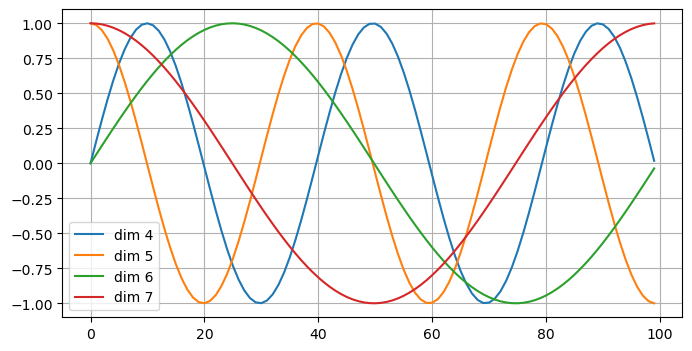

In [17]:
"""
Test the PositionalEncoding class with a toy model for 4 dimensions. 
The  4th  dimension has the same frequency as the 5th but with different offset (i.e. phase)
because one is produced by a sine function and the other is produced by a cosine function. 
The  6th  and  7th  dimensions have lower frequency.
"""
import matplotlib.pyplot as plt
import numpy as np

pe = PositionalEncoding(num_hiddens=20, dropout=0)
pe.eval()
Y = pe(torch.zeros((1, 100, 20))).data.cpu().numpy()  # 1 example, 100 words with embedding dim of 20
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
for p in [4, 5, 6, 7]:
    ax.plot(np.arange(100), Y[0, :, p].T, label=f'dim {p}')
ax.legend()
ax.grid()

In [18]:
# Embeddings class: sequences -> features

class Embeddings(nn.Module):
    def __init__(self, d_model, vocab_size, max_position_embeddings, dropout=0):
        super().__init__()
        self.dropout = dropout
        self.word_embeddings = nn.Embedding(vocab_size, d_model, padding_idx=1)
        self.position_embeddings = PositionalEncoding(num_hiddens=d_model, dropout=self.dropout,
                                                      max_len=max_position_embeddings)
        self.LayerNorm = nn.LayerNorm(d_model, eps=1e-12)
        self.d_model = d_model

    def forward(self, input_ids):
        seq_length = input_ids.size(1)
        
        # Get word embeddings for each input id
        word_embeddings = self.word_embeddings(input_ids)                   # (bs, max_seq_length, dim)
        # Get position embeddings for the word embeddings and add them     
        embeddings = self.position_embeddings(word_embeddings) # (bs, max_seq_length, dim)
        
        # Layer norm 
        embeddings = self.LayerNorm(embeddings)             # (bs, max_seq_length, dim)
        return embeddings

In [19]:
# Transformer encoder
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, hidden_dim_mult=4, dropout=0.1):
        super().__init__()
        
        self.dropout = dropout
        self.mha = MultiHeadAttention(d_model, num_heads, dropout=dropout)
        self.ffn = FFN(d_model, hidden_dim_mult, dropout)

        self.layernorm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
    
    def forward(self, x):
        
        # Multi-head attention 
        attn_output, _ = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)
        
        # Layer norm after adding the residual connection 
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        # Feed forward 
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        
        # Second layer norm after adding residual connection 
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, ff_hidden_dim_mult, input_vocab_size,
               maximum_position_encoding, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.dropout = dropout

        self.embedding = Embeddings(d_model, input_vocab_size, maximum_position_encoding, dropout)

        self.enc_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.enc_layers.append(EncoderLayer(d_model, num_heads, ff_hidden_dim_mult, self.dropout))
        
    def forward(self, x):
        x = self.embedding(x) # Transform to (batch_size, input_seq_length, d_model)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # (batch_size, input_seq_len, d_model)

In [20]:
# Transormer classifier for sentiment analysis
class TransformerClassifier(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, ff_hidden_dim_mult, input_vocab_size, num_answers):
        super().__init__()
        
        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, ff_hidden_dim_mult, input_vocab_size,
                                          maximum_position_encoding=10000)
        self.dense = nn.Linear(d_model, num_answers)

    def forward(self, x):
        x = self.encoder(x)  # [batch_size, seq_len, d_model]
        # pooling
        x, _ = torch.max(x, dim=1)  # [batch_size, d_model], can also use torch.mean(dim=1) or just x[:, -1]
        x = self.dense(x)  # [batch_size, num_answers]
        return x

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vocab_size = len(vocab)
model = TransformerClassifier(num_layers=1, d_model=32, num_heads=2, 
                              ff_hidden_dim_mult=4, input_vocab_size=vocab_size, num_answers=2)
model.to(device)

TransformerClassifier(
  (encoder): TransformerEncoder(
    (embedding): Embeddings(
      (word_embeddings): Embedding(55000, 32, padding_idx=1)
      (position_embeddings): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
    )
    (enc_layers): ModuleList(
      (0): EncoderLayer(
        (mha): MultiHeadAttention(
          (W_q): Linear(in_features=32, out_features=32, bias=False)
          (W_k): Linear(in_features=32, out_features=32, bias=False)
          (W_v): Linear(in_features=32, out_features=32, bias=False)
          (W_h): Linear(in_features=32, out_features=32, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ffn): FFN(
          (fc_1): Linear(in_features=32, out_features=128, bias=True)
          (act): ReLU(inplace=True)
          (proj): Linear(in_features=128, out_features=32, bias=True)
          (dropout): Dropout(p=0.1, inplace=Fals

In [22]:
# collate_fn processes sample from DataLoader according to the data processing pipelines declared previously. 
# label is a tensor saving the labels of individual text entries.
max_seq_len = 200

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text)[:max_seq_len], dtype=torch.int64)
        if processed_text.shape[0] < max_seq_len:
            pad = vocab(['<pad>'])[0] * torch.ones(max_seq_len - len(processed_text), dtype=torch.int64, device=processed_text.device)
            processed_text = torch.cat([processed_text, pad])
        text_list.append(processed_text)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = torch.stack(text_list, dim=0)
    return label_list.to(device), text_list.to(device)

In [23]:
# functions for training and evaluation
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text) in enumerate(dataloader): 
        predicted_label = model(text)
        # print(f'predicted_label: {predicted_label.shape}, label: {label.shape}')
        loss = criterion(predicted_label, label)
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(f"| epoch {epoch:3d} | {idx:5d}/{len(dataloader):5d} batches| accuracy {total_acc / total_count:8.3f}")
            total_acc, total_count = 0, 0
            start_time = time.time()


def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [27]:
# hyper-parameters
batch_size = 128
epochs = 10
lr = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

In [28]:
# split and prepare dataset
train_iter, test_iter = IMDB(root='./datasets/imdb/aclImdb/')
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [29]:
# train loop
total_accu = None
for epoch in range(epochs):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    total_accu = accu_val
    print("-" * 59)
    print(f"| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s | valid accuracy {accu_val:8.3f}")
    print("-" * 59)

-----------------------------------------------------------
| end of epoch   0 | time: 11.51s | valid accuracy    0.835
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   1 | time: 11.08s | valid accuracy    0.834
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time: 10.96s | valid accuracy    0.843
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time: 12.04s | valid accuracy    0.866
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time: 10.96s | valid accuracy    0.877
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time: 10.95s | vali

In [30]:
# evaluation on test set
accu_test = evaluate(test_dataloader)
print(f"test accuracy {accu_test:8.3f}")

test accuracy    0.829


#### Transformer's Decoder Module
---
<center><img src="./assets/transformer_decoder.png" style="height:350px"></center>

<a href="https://jalammar.github.io/illustrated-transformer/">Image Source</a>

* The Transformer decoder block looks similar to the Transformer encoder block. 
* However, besides the two sub-layers (the multi-head attention layer and the positional encoding network), the decoder Transformer block contains a third sub-layer, which applies multi-head attention on the output of the encoder stack.
* **Cross-attention**: The cross attention follows the query, key, and value setup used for the self-attention blocks. However, the inputs are a little more complicated. 
    * The input to the decoder is a data point $y_i$, which is then passed through the self-attention and add-norm blocks, and finally ends up at the cross-attention block. 
    * This serves as the **query** for cross-attention, where the **key and value** pairs are the output $h^{Enc}$, where this output is calculated with all past inputs $x_1, ..., x_t$.
* During training, the output for the $t$-query could observe all the previous key-value pairs. 
* It results in a different behavior from prediction. Thus, during *prediction* we can eliminate the unnecessary information by specifying the valid length to be $t$ for the $t^{th}$ query.
* The output probabilities predict the next token in the output sentence.
* During training, we can use "Teacher Forcing" which allows us to use the labels from the data; however, during inference, the decoding part is done *iteratively*.

### <img src="https://img.icons8.com/plasticine/100/000000/teacher.png" style="height:50px;display:inline"> Teacher Forcing
---
* Teacher forcing is a strategy for training sequential neural networks that use model output from a prior time step as an input.
* Teacher forcing works by using the actual or expected output from the training dataset at the current time step $y_t$ as input in the next time step $X_{t+1}$, rather than the output generated by the network.
* This startegy allows for faster training, especially in RNNs.

<center><img src="./assets/transformer_decoding_2.gif" style="height:500px"></center>

<a href="https://jalammar.github.io/illustrated-transformer/">Animation by Jay Alammar</a>

#### Transformer Architecture Summary
---

<center><img src="./assets/transformer_arch_sum.png" style="height:500px"></center>

<a href="https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html#transformer_model_architecture">Image Source</a>

### <img src="https://img.icons8.com/cotton/64/000000/torch.png" style="height:50px;display:inline"> Native Transformer in PyTorch
---
* Transformer is implmented natively in PyTorch:<br>`torch.nn.Transformer(d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1, activation='relu', custom_encoder=None, custom_decoder=None, layer_norm_eps=1e-05, batch_first=False, norm_first=False, device=None, dtype=None)`
* <a href="https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html">Documentation</a>
* <a href="https://github.com/pytorch/examples/blob/main/word_language_model/main.py">Code example usage</a>

## <img src="https://img.icons8.com/emoji/96/000000/woman-lifting-weights.png" style="height:50px;display:inline"> Pretrained Models - BERT and GPT
---
* Large-scale pretrained models have gained popularity over the past years, as big companies can train very large models, which are then published for the public to use as-is or to use with fine-tuning for the users' custom datasets.
* **Bidirectional Encoder Representations from Transformers (BERT), Google** - a Transformer-based machine learning technique for natural language processing (NLP) pre-training developed by Google. The idea is to mask certain words and then try to predict them. The original English-language BERT model comes with two pre-trained general types:
    * (1) the $BERT_{BASE}$ model, a 12-layer, 768-hidden, 12-heads, 110M parameter neural network architecture.
    * (2) the $BERT_{LARGE}$ model, a 24-layer, 1024-hidden, 16-heads, 340M parameter neural network architecture. 
    * Both of which were trained on the BooksCorpus dataset with 800M words, and a version of the English Wikipedia with 2,500M words.
    * Extensions: RoBERTa (Facebook), DistillBERT (HuggingFace)
* **Generative Pre-trained Transformer (GPT), OpenAI** - an autoregressive language model that uses deep learning to produce human-like text. GPT was trained with a causal language modeling (CLM) objective and is therefore powerful at predicting the next token in a sequence. The proposed method utilizes generative pre-training of a language model on a diverse corpus of unlabeled text, followed by discriminative fine-tuning on each specific task. Unlike BERT, GPT is a generative model, while BERT is an effective pretrained model for embeddings of words/sentences.
    * GPT Demo - <a href="https://transformer.huggingface.co/doc/gpt">Write With Transformer</a>.
* <a href="https://huggingface.co/">HuggingFace</a> is a company that is dedicated to publishing all of the available pretrained models and it works in PyTorch as well - <a href="https://github.com/huggingface/transformers">HuggingFace Transformers</a>.
* <a href="https://pytorch.org/hub/huggingface_pytorch-transformers/">Examples with PyTorch</a>.

<center><img src="./assets/gpt_3_train.gif" style="height:400px"></center>

<a href="https://jalammar.github.io/how-gpt3-works-visualizations-animations/">Animation by Jay Alammar</a>

<a href="https://huggingface.co/models">HF Models Hub</a>

<center><img src="./assets/huggingface.PNG" style="height:500px"></center>

## <img src="https://img.icons8.com/bubbles/50/null/picture.png" style="height:50px;display:inline"> Vision Transformer (ViT)
---
* Instead of word tokens, we can think of image patches as our "words", i.e., we treat image patches as tokens.
* This enables employing a Transformer architecture for vision tasks!
* First, an image is split into fixed-size patches, each of them are then linearly embedded. Then, 2D position embeddings are added, and the resulting sequence of vectors is fed to a standard Transformer encoder. 
* In order to perform classification, an extra learnable “classification token” is added to the sequence, similarly to Transformer-based NLP tasks.
* Transformers require a large amount of data for high accuracy, thus, in the case of having less data, CNNs generally perform better than Transformers.
* To reach high performance of ViT, usuall pre-training using a large-size dataset is employed, as its dependence on a large dataset is interpreted as due to low locality inductive bias, an important property of CNNs.


* <a href="https://pytorch.org/vision/main/models/vision_transformer.html">Official ViT Pre-trained Models in PyTorch</a>.
* <a href="https://github.com/lucidrains/vit-pytorch">ViT Models and Examples with PyTorch</a>.

<center><img src="./assets/vit_gif_wiki.gif" style="height:400px"></center>

<a href="https://en.wikipedia.org/wiki/Vision_transformer">Image Source</a>

In [ ]:
# code skeleton from: https://lightning.ai/docs/pytorch/latest/notebooks/course_UvA-DL/11-vision-transformer.html

def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x

class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:, : T + 1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

## <img src="https://img.icons8.com/external-others-maxicons/62/null/external-magic-medieval-others-maxicons.png" style="height:50px;display:inline"> How to Tame Your Transformer?
---
* Transformers are notoriously hard to train as they are sensitive to the size of your dataset and the choice of hyperparameters including the learning rate, batch size and optimizer.
* Following is a collection of tips and tricks that make Transformers much more stable and converge faster.
* For a more detailed analysis, check out <a href="https://www.borealisai.com/research-blogs/tutorial-17-transformers-iii-training/">Tricks For Training Transformers - Borealis AI - P. Xu, S. Prince</a>.

### <img src="https://img.icons8.com/clouds/100/rocket.png" style="height:50px;display:inline"> Initialization
---
* Initialization matters in LLMs, not only for stability, but also for the final performance!
    * <a href="https://github.com/bigscience-workshop/bigscience/blob/master/train/lessons-learned.md">BLOOM: Lessons Learned in Training LLMs</a>
* **Transformer initialization**: there are many approaches, and papers, but the ground rule is using low standard deviations for the initialization distribution (which is usually normal/Gaussian).
    * GPT and T5 have similar initializations (up to small differences in the STDs).
* Using PyTorch’s attention and transformer modules: it is better to initialize them manually as the default initialization is not good enough.
* LLMs require more carful initialization which is depth-dependent (i.e., how deeper the layer is in the network):
    * **T-Fixup**: <a href="https://proceedings.mlr.press/v119/huang20f.html">“Improving Transformer Optimization Through Better Initialization”. Huang et al., ICML 2020</a>.
    * **DT-Fixup**: <a href="https://arxiv.org/abs/2012.15355">"Optimizing deeper transformers on small datasets.“ Peng et al, ACL 2021</a>.
    * **Admin**: <a href="https://arxiv.org/abs/2004.08249">"Understanding the difficulty of training transformers.“. Liu et al., EMNLP 2020</a>.
    * **GradInit**: <a href="https://arxiv.org/abs/2102.08098">"Gradinit: Learning to initialize neural networks for stable and efficient training." Chen et al., NeurIPS 2021</a>.
    * **DS-Init**: <a href="https://arxiv.org/abs/1908.11365">"Improving deep transformer with depth-scaled initialization and merged attention.“. Biao et al., 2019</a>.
    * **Mimetic-Init** (ViTs): <a href="https://arxiv.org/abs/2305.09828">"Mimetic Initialization of Self-Attention Layers", Trockman and Kolter., 2023</a>.

In [ ]:
# GPT initialization example
# https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
def _init_weights(self, module):
    if isinstance(module, nn.Linear):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    elif isinstance(module, nn.LayerNorm):
        torch.nn.init.zeros_(module.bias)
        torch.nn.init.ones_(module.weight)

### <img src="https://img.icons8.com/external-flaticons-lineal-color-flat-icons/64/null/external-workout-running-flaticons-lineal-color-flat-icons-4.png" style="height:50px;display:inline"> Learning Rate Warm-Up
---
* **Learning rate warm-up**: the learning rate is gradually increased during the early stages of training.
* While this is not typically required for most deep learning architectures, for Transformers training fails if we just start with a typical learning rate. 
* If we *start with a very small learning rate*, then the training is stable, but then it takes an impractically long time.
* <a href="https://arxiv.org/abs/2002.04745">Xiong et al., 2020</a> conducted several experiments with different optimizers and learning rate schedules. Their results show that **learning rate warm-up is essential for both Adam and SGD**, and that the training process is sensitive to the warm-up steps.

<center><img src="./assets/transformers_warmup.PNG" style="height:400px"></center>

* Although learning rate warm-up works, it has some obvious disadvantages -- it introduces an extra hyper-parameter - the number of warm-up steps, and it initializes the learning rate to zero which slows the training down.
* <a href="https://www.cs.toronto.edu/~mvolkovs/ICML2020_tfixup.pdf">Huang et al., 2020</a> found that without warm-up, the gradients vanish very quickly, and the Adam updates also rapidly become much smaller.
*  <a href="https://arxiv.org/abs/2004.08249">Liu et al., 2020</a> observed that differentiating through the self-attention mechanism creates unbalanced gradients. 
    * In particular, the gradients for the query $W_q$ and key $W_k$ parameters were much smaller than those for the value parameters $W_v$, and so the former parameters change much more slowly.

* **Gradient Shrinkage Effect**: <a href="https://arxiv.org/abs/2002.04745">Xiong et al., 2020</a> found that the magnitude of the gradients through layer normalization is inversely proportional to magnitude of the input. Specifically, the gradient has the following property: $$   \left\lVert \frac{\partial \bf Layernorm[\mathbf{X}]}{\partial \mathbf{X}} \right\rVert=\mathcal{O}\left(\frac{\sqrt{D}}{\lVert\mathbf{X}\rVert}\right), $$ where $X$ is the input to layer normalization and $D$ is the embedding dimension.
* If the input norm $||X||$ is larger than $\sqrt{D}$ then back-propagating through layer normalization *reduces* the gradient magnitude in lower layers. As this effect compounds through multiple layers, it causes **the gradient to vanish at lower layers for deep models**.
* Moreover, using adaptive optimizers like Adam aggravates the gradient shrinkage effect as the variance of the Adam updates is unbounded at the start of training, and these updates are also known to exhibit high variance in the early stages of training.
* This can lead to *problematic large updates* early on, which can make the input norm $||X||$ to each layer increase as we move through the network and thus the increased gradient shrinkage.

* Finally, residual connections are required in the Transformer architecture for the ease of optimization, which further requires layer normalization to avoid gradient explosion and adaptive optimizers like Adam to address unbalanced gradients in the self-attention blocks. 
* On the other hand, the use of layer normalization causes the gradients to shrink in the early layers and also amplifies the output perturbations. 
* Moreover, the instability of Adam in the early stages of training exacerbates both of these effects.
* **Learning rate warm-up** effectively stabilizes the Adam updates during the early stages of training by making the parameter changes much smaller. Consequently, Adam no longer aggravates gradient shrinkage and amplification of output perturbations and training becomes relatively stable.

<center><img src="./assets/transformer_warmup_d.PNG" style="height:500px"></center>

In [ ]:
# learning rate warmup scheduler example
class CosineWarmupScheduler(torch.optim.lr_scheduler._LRScheduler):
    # https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor
    
# usage - similar to all other scheduelrs
warmup = 3 * len(dataloader)
max_iter = 50 * len(dataloader)
scheduler = CosineWarmupScheduler(optimizer, warmup=warmup, max_iters=max_iter)

### <img src="https://img.icons8.com/external-flaticons-lineal-color-flat-icons/64/external-activation-media-agency-flaticons-lineal-color-flat-icons.png" style="height:50px;display:inline"> GLU Variants Activations
---
* <a href="https://arxiv.org/abs/2002.05202">GLU Variants Improve Transformer</a> - Noam Shazeer, 2020.
* The ReLU activation in the FFN (MLP) part of the Transformer can be replaced with variants from the Gated Linear Units (GLU) family for improved performance.
* Gated Linear Units consist of the component-wise product of two linear projections, one of which is first passed through a sigmoid function.

<center><img src="./assets/ffn_glu.PNG" style="height:150px"></center>

* The reason?
    * *"We offer no explanation as to why these 
architectures seem to work; we attribute their success, as all else, to divine benevolence"* (from the Conclusion section of the paper)."

In [ ]:
from torch.nn import functional as F
# replace FFN with FFNSwiglu
class FFNSwiglu(nn.Module):
    def __init__(self, d_model, hidden_dim_multiplier=4, resid_pdrop=0.1):
        super().__init__()
        self.w1 = nn.Linear(d_model, hidden_dim_multiplier * d_model, bias=False)
        self.w2 = nn.Linear(hidden_dim_multiplier * d_model, d_model, bias=False)
        self.w3 = nn.Linear(d_model, hidden_dim_multiplier * d_model, bias=False)

        self.dropout = nn.Dropout(resid_pdrop)

    def forward(self, x):
        x = self.dropout(self.w2(F.silu((self.w1(x))) * self.w3(x)))
        return x

<center><img src="./assets/glu_variants_benchmark.PNG" style="height:250px"></center>

### <img src="https://img.icons8.com/nolan/64/replace.png" style="height:50px;display:inline"> Alternatives to (Post) Layer Normalization
---
* As the problems we introduced above are directly connected to layer normalization, it is natural to question whether we can train deep transformer models without it. 
* Indeed, it is possible! sometimes we can achieve even better generalization without layer normalization.

* **Pre-LN Transformers**: a simple solution to balance the residual dependencies which will limit the output perturbations and mitigate the problem of gradient vanishing.
* Pre-LN changes the location of layer normalization inside the transformer layer so that it occurs inside the residual blocks and before the self-attention or MLP. This simple change can help control the gradient magnitude and balance the residual dependencies.
* Pre-LN transformer models can be trained **without learning rate warm-up**. However, they sometimes lead to inferior empirical performance. 

<center><img src="./assets/transformers_preln.PNG" style="height:400px"></center>

In [ ]:
class EncoderLayerPreLN(nn.Module):
    def __init__(self, d_model, num_heads, hidden_dim_mult=4, dropout=0.1):
        super().__init__()
        
        self.dropout = dropout
        self.mha = MultiHeadAttention(d_model, num_heads, dropout=dropout)
        self.ffn = FFN(d_model, hidden_dim_mult, dropout)

        self.layernorm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
    
    def forward(self, x):
        
        # pre-ln
        x = self.layernorm1(x)
        
        # Multi-head attention 
        attn_output, _ = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)
        
        # the first residual connection 
        out1 = x + attn_output  # (batch_size, input_seq_len, d_model)
        
        # Feed forward + pre-ln 
        ffn_output = self.ffn(self.layernorm2(out1))  # (batch_size, input_seq_len, d_model)
        
        # the second residual connection 
        out2 = out1 + ffn_output  # (batch_size, input_seq_len, d_model)

In [ ]:
# in pytorch set `norm_first=True`
model = torch.nn.Transformer(d_model=512,
                             nhead=8, num_encoder_layers=6,
                             num_decoder_layers=6,
                             dim_feedforward=2048,
                             dropout=0.1,
                             activation='silu',
                             batch_first=True,
                             norm_first=True)  # pre-ln: norm_first=True

* **ReZero**: <a href="https://arxiv.org/abs/2003.04887">Bachlechner et al., 2020</a> propose to remove the layer normalization and introduces a single trainable parameter $\alpha$ per residual layer so that the self-attention block residual layer becomes, $\mathbf{X} + \alpha\bf MhSa[\mathbf{X}]$, where $\alpha$ is initialized to zero.
* The result of this is that the entire network is initialized just to compute the identity function, and the contributions of the self-attention and MLP layers are gradually and adaptively introduced.

<center><img src="./assets/transformer_rezero.PNG" style="height:150px"></center>

In [ ]:
# for more examples, check out https://github.com/majumderb/rezero, 
# https://github.com/tbachlechner/ReZero-examples/blob/master/ReZero-Deep_Fast_Transformer.ipynb
class EncoderLayerReZero(nn.Module):
    def __init__(self, d_model, num_heads, hidden_dim_mult=4, dropout=0.1):
        super().__init__()
        
        self.dropout = dropout
        self.mha = MultiHeadAttention(d_model, num_heads, dropout=dropout)
        self.ffn = FFN(d_model, hidden_dim_mult, dropout)

        # instead of LN, we use a learnable alpha parameter initialized to zero
        self.resweight = nn.Parameter(torch.tensor([0.0]), requires_grad=True)
    
    def forward(self, x):
        # Multi-head attention 
        attn_output, _ = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)
        
        # the first residual connection + rezero
        out1 = x + attn_output * self.resweight  # (batch_size, input_seq_len, d_model)
        
        # Feed forward
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        
        # the second residual connection + rezero
        out2 = out1 + ffn_output * self.resweight  # (batch_size, input_seq_len, d_model)

* **SandwichNorm**: why not both?
    * This technique first made an appearance in the CoqView paper, a Chinese version of the famous text-to-image transformer DALL-E. 
    * They propose, when using Pre-LN, to add an extra LN to all the branch outputs. 
    * Some people found this to be very effective when facing instability during training.
    
<center><img src="./assets/sandwich_norm.png" style="height:200px"></center>

<a href="https://arxiv.org/abs/2105.13290">Image Source</a>

* **RMSNorm**: LN, but without mean centering and learned bias.
    * Faster than LN.
    * <a href="https://arxiv.org/abs/2102.11972">An investigative paper</a> found this to be the best performing normalization variant.
    * Extensive experiments on several tasks using diverse network architectures show that RMSNorm achieves comparable performance against LayerNorm but reduces the running time by 7%∼64% on different models.
    * Usually in post-LN configuration.
    
$$ y_i = \text{RMSNorm}(x_i)=\gamma_i \hat{x}_i \in \mathbb{R}^d $$
$$ \hat{x}_i = \frac{x_i}{\sqrt{\frac{1}{d}\sum_{l=1}^d x_{i,l}^2}} $$

In [ ]:
# https://github.com/lucidrains/x-transformers
class RMSNorm(nn.Module):
    def __init__(self, dim, eps = 1e-8):
        super().__init__()
        self.scale = dim ** -0.5
        self.eps = eps
        self.g = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        norm = torch.norm(x, dim=-1, keepdim=True) * self.scale
        return self.g * x / norm.clamp(min=self.eps)

<center><img src="./assets/transformer_norm_comparison.png" style="height:300px"></center>

<a href="https://arxiv.org/abs/2102.11972">Image Source</a>

### <img src="https://img.icons8.com/clouds/100/null/support.png" style="height:50px;display:inline"> Rectified Adam (RAdam) - Reducing Adam's Variance
---
* <a href="https://arxiv.org/abs/1908.03265">Liu et al., (2019)</a> argue that the high variance of learning rates in the Adam optimizer at the early stages of training is due to the lack of samples in the early stages of learning.
* They base their argument on an experiment in which they do not change the model parameters or momentum term of Adam for the first 2000 learning steps, but only adapt the learning rate.
    * After this, warm-up is no longer required!
* They propose **Rectified Adam or RAdam** which gradually changes the momentum term over time in a way that helps avoid high variance. 
    * One way to think of this is that we have effectively incorporated learning rate warm-up into the Adam algorithm, but in a principled way.
* <a href="https://nn.labml.ai/optimizers/radam.html">Step-by-step algorithm and implementation</a>.

<center><img src="./assets/transformer_radam.PNG" style="height:300px"></center>

* Training loss v.s. # of iterations of Transformers on the De-En IWSLT’14 dataset (machine translation).

In [ ]:
# RAdam in pytorch: https://pytorch.org/docs/stable/generated/torch.optim.RAdam.html#torch.optim.RAdam
optimizer = torch.optim.RAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

### <img src="https://img.icons8.com/nolan/64/123.png" style="height:50px;display:inline"> Positional Encodings/Embeddings/Bias
---
* Transformers are stripped of any inductive bias (e.g, locality of CNNs).
* Positional embeddings are crucial for sequence modeling with transformers.
* Positional encodings can be *learned* or *constant*, and they can **absolute** or **relative**.
* **Vanilla transformers**: constant absolute positional encodings (sine and cosine).
* In addition, instead of adding the positional encodings before the input the transformer, they can be **directly injected to the attention matrix**, which usually results in better performance.
* For example, GPT-3 uses *learned* **absolute** positional encodings, while T5 uses *learned* **relative** positional bias.

<center><img src="./assets/att_pos_enc_table.png" style="height:200px"></center>

<a href="https://arxiv.org/abs/2102.11090">Image Source</a>

* **Relative Positional Encoding (RPE)**: Relative positional encoding (RPE) is added directly to the attention matrix!
    * Also termed “relative positional bias”.
* Currently, RPE is superior to absolute positional encoding (APE) and it has become the standard in all recent LLMs.
* There are several approaches to calculate the relative positional bias matrix, and the values can be learned or pre-determined.
* Some popular recent positional encodings:
    * Simple Relative Positional Bias (used in T5).
    * Attention with Linear Biases (ALiBi).
    * Rotary Positional Embeddings (RoPE, used in PaLM).
* <a href="https://github.com/lucidrains/x-transformers/blob/52bcac25437064757d8c4e5bd9e77b9598b462bb/x_transformers/x_transformers.py#L227">Code Examples</a>

<center><img src="./assets/att_rpe.png" style="height:300px"></center>

<a href="https://paperswithcode.com/method/relative-position-encodings">Image Source</a>

### <img src="https://img.icons8.com/bubbles/50/refresh.png" style="height:50px;display:inline"> Staying Up-to-Date with Transformers
---
* The field is moving very fast!
* How can we keep track of all the new improvements?
* Recommended repository: https://github.com/lucidrains/x-transformers
* Other recommended repositories:
    * https://github.com/facebookresearch/fairseq
    * https://github.com/microsoft/unilm

### <img src="https://img.icons8.com/bubbles/50/000000/video-playlist.png" style="height:50px;display:inline"> Recommended Videos
---
#### <img src="https://img.icons8.com/cute-clipart/64/000000/warning-shield.png" style="height:30px;display:inline"> Warning!
* These videos do not replace the lectures and tutorials.
* Please use these to get a better understanding of the material, and not as an alternative to the written material.

#### Video By Subject

* Deep Learning for Natural Language Processing (NLP) -  <a href="https://youtu.be/6D4EWKJgNn0"> Deep Learning for Natural Language Processing (NLP) </a>
    * Attention and the Transformer <a href="https://www.youtube.com/watch?v=f01J0Dri-6k&feature=youtu.be">Practicum: Attention and the Transformer</a>

* Recurrent Neural Networks - <a href="https://www.youtube.com/watch?v=SEnXr6v2ifU"> Recurrent Neural Networks | MIT 6.S191 </a>

* LSTM & GRU - <a href="https://www.youtube.com/watch?v=8HyCNIVRbSU"> Illustrated Guide to LSTM's and GRU's: A step by step explanation </a>

* Transformers - <a href="https://www.youtube.com/watch?v=S27pHKBEp30">LSTM is dead. Long Live Transformers! </a>
* BERT - <a href="https://www.youtube.com/watch?v=OR0wfP2FD3c">BERT Explained!</a>
* GPT - <a href="https://www.youtube.com/watch?v=9ebPNEHRwXU">GPT Explained!</a>
    * GPT-3 - <a href="https://www.youtube.com/watch?v=_x9AwxfjxvE">OpenAI GPT-3 - Good At Almost Everything!</a>
* Vision Transformer (ViT) - <a href="https://www.youtube.com/watch?v=TrdevFK_am4">An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale</a>
* Relative Positional Encoding - <a href="https://www.youtube.com/watch?v=7XHucAvHNKs">Relative Positional Encoding for Transformers with Linear Complexity</a>
* Rotary Positional Embeddings - <a href="https://www.youtube.com/watch?v=o29P0Kpobz0">Rotary Positional Embeddings: Combining Absolute and Relative</a>

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Icons made by <a href="https://www.flaticon.com/authors/becris" title="Becris">Becris</a> from <a href="https://www.flaticon.com/" title="Flaticon">www.flaticon.com</a>
* Icons from <a href="https://icons8.com/">Icons8.com</a> - https://icons8.com
* <a href="https://d2l.ai/chapter_recurrent-neural-networks/index.html">Dive Into Deep Learning - Recurrent Neural Networks</a>
* <a href="https://atcold.github.io/pytorch-Deep-Learning/en/week12/12-1/">DS-GA 1008 - NYU CENTER FOR DATA SCIENCE - Deep Sequence Modeling</a>
* <a href="https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html">Text classification with the torchtext library
</a>
* <a href="https://www.borealisai.com/research-blogs/tutorial-17-transformers-iii-training/">Tricks For Training Transformers - Borealis AI - P. Xu, S. Prince</a>